In [6]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as TF
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIGURATION OPTIMALE POUR CPU (MODE NUIT) ---
class Config:
    TRAIN_CSV = "train_metadata.csv"
    SUB_CSV = "sample_submission.csv"
    TRAIN_DIR = "train_images"
    TEST_DIR = os.path.join("test_images", "mistery_cat")
    
    NUM_CLASSES = 20
    IMG_SIZE = 256        # Taille augmentée pour mieux voir les détails (vs 224)
    BATCH_SIZE = 16       # Compromis vitesse/mémoire pour CPU
    EPOCHS = 12           # Suffisant car on multiplie par 5 Folds
    LR = 2e-4             # Learning rate
    N_FOLDS = 5           # 5 modèles vont être entraînés (Cross-Validation)
    DEVICE = "cpu"        # Force CPU

# Gestion des images corrompues
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Reproductibilité totale
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything()
print(f"Mode 'Nuit Blanche' activé : {Config.N_FOLDS} Folds, Resolution {Config.IMG_SIZE}px, Device: {Config.DEVICE}")

Mode 'Nuit Blanche' activé : 5 Folds, Resolution 256px, Device: cpu


In [7]:
class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        # Gestion du cas Test où 'class_idx' n'existe pas
        if 'class_idx' not in self.df.columns:
            self.df['class_idx'] = 0 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['path'])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, int(row['class_idx'])

# --- FONCTIONS MIXUP ---
def mixup_data(x, y, alpha=0.4):
    """Mélange deux images pour l'entraînement"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calcule la perte pondérée"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [8]:
def get_mean_std(df, img_dir, img_size):
    print("Calcul des statistiques précises des couleurs (Patientez 1-2 min)...")
    temp_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    
    # On utilise tout le dataset pour le calcul
    dataset = BirdDataset(df, img_dir, transform=temp_transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    
    mean = 0.
    std = 0.
    nb_samples = 0.
    
    for data, _ in tqdm(loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean.tolist(), std.tolist()

# Lancement du calcul
full_df = pd.read_csv(Config.TRAIN_CSV)
custom_mean, custom_std = get_mean_std(full_df, Config.TRAIN_DIR, Config.IMG_SIZE)

print(f"\nStats Dataset -> Mean: {custom_mean} | Std: {custom_std}")
print("Ces valeurs seront utilisées pour calibrer la vision du modèle.")

Calcul des statistiques précises des couleurs (Patientez 1-2 min)...


100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Stats Dataset -> Mean: [0.49644598364830017, 0.5174545049667358, 0.43692541122436523] | Std: [0.19207711517810822, 0.19212645292282104, 0.20007923245429993]
Ces valeurs seront utilisées pour calibrer la vision du modèle.


Génération d'un aperçu pour les 20 classes...


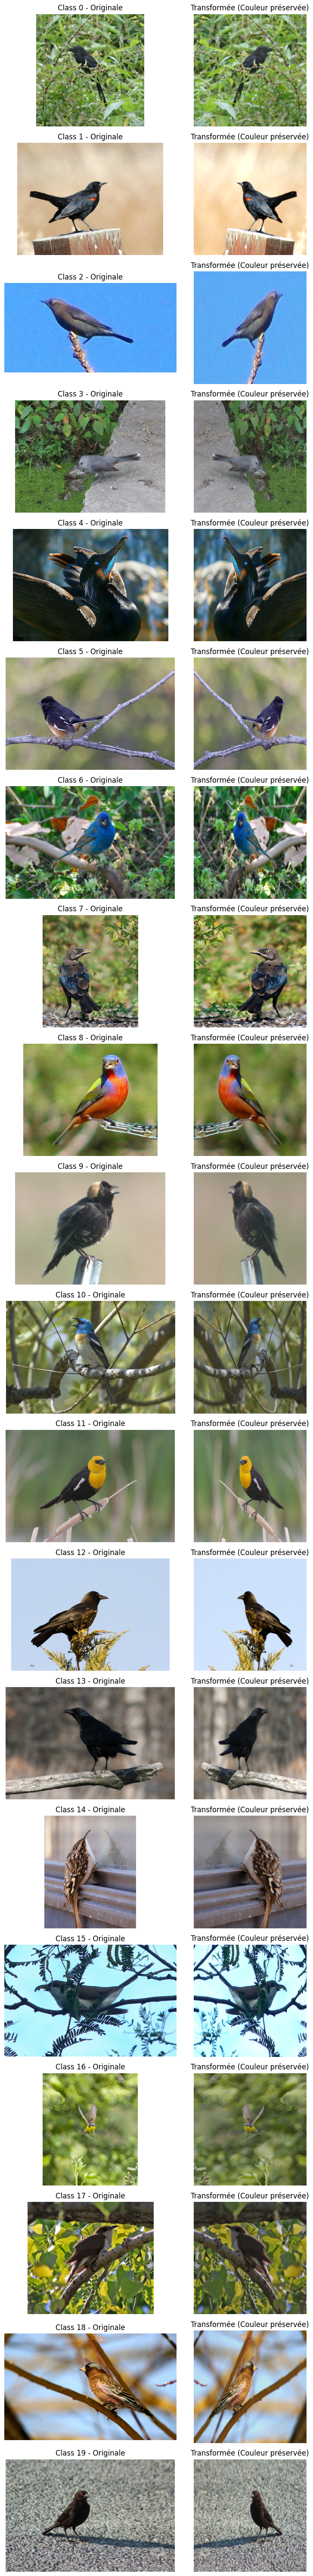

In [9]:
def visualize_transformations(df, img_dir, mean, std):
    classes = df['class_idx'].unique()
    classes.sort()
    
    # Augmentation pour la visualisation (sans normalisation pour l'affichage humain)
    viz_transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        # C'est ici qu'on vérifie la sécurité des couleurs
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
        transforms.RandomHorizontalFlip(p=1.0), # On force le flip pour voir l'effet
        transforms.ToTensor()
    ])
    
    print(f"Génération d'un aperçu pour les {len(classes)} classes...")
    fig, axes = plt.subplots(len(classes), 2, figsize=(8, 3*len(classes)))
    
    for i, cls_idx in enumerate(classes):
        row = df[df['class_idx'] == cls_idx].iloc[0]
        img_path = os.path.join(img_dir, row['path'])
        
        orig = Image.open(img_path).convert("RGB")
        res = viz_transform(orig).permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(orig)
        axes[i, 0].set_title(f"Class {cls_idx} - Originale")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(res)
        axes[i, 1].set_title(f"Transformée (Couleur préservée)")
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_transformations(full_df, Config.TRAIN_DIR, custom_mean, custom_std)

In [10]:
def get_model(num_classes):
    # ConvNeXt Tiny pré-entraîné
    model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
    # Adaptation de la dernière couche
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
    return model

# Préparation des K-Folds
skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=42)
fold_scores = []

# --- DÉBUT DE LA BOUCLE PRINCIPALE ---
for fold, (train_idx, val_idx) in enumerate(skf.split(full_df, full_df['class_idx'])):
    print(f"\n{'='*15} FOLD {fold+1}/{Config.N_FOLDS} - DÉBUT {'='*15}")
    
    # 1. Préparation Dataframes & Loaders
    train_fold = full_df.iloc[train_idx]
    val_fold = full_df.iloc[val_idx]
    
    # Pipeline d'entraînement : Géométrie + Lumière + Normalisation Custom
    train_tf = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(),      # Miroir
        transforms.RandomRotation(10),          # Rotation légère
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0), # Couleurs sûres
        transforms.ToTensor(),
        transforms.Normalize(custom_mean, custom_std)
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(custom_mean, custom_std)
    ])
    
    train_ds = BirdDataset(train_fold, Config.TRAIN_DIR, transform=train_tf)
    val_ds = BirdDataset(val_fold, Config.TRAIN_DIR, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0)
    
    # 2. Initialisation Modèle
    model = get_model(Config.NUM_CLASSES).to(Config.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=1e-2)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS)
    
    # LABEL SMOOTHING (0.1) : Le modèle est moins "arrogant"
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    best_acc = 0.0
    
    # 3. Boucle d'Époques
    for epoch in range(Config.EPOCHS):
        model.train()
        running_loss = 0.0
        
        # Barre de progression
        pbar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}", leave=False)
        
        for images, labels in pbar:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            optimizer.zero_grad()
            
            # Application du MixUp (50% de chance)
            if np.random.rand() < 0.5:
                images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.4)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        scheduler.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        print(f"   Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f} | Val Acc: {acc:.2f}%")
        
        # Sauvegarde du meilleur checkpoint pour ce Fold
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"model_fold_{fold}.pth")
    
    print(f"-> Résultat Final Fold {fold+1}: {best_acc:.2f}%")
    fold_scores.append(best_acc)
    
    # Nettoyage mémoire pour le fold suivant
    del model, optimizer, train_loader, val_loader

print(f"\n{'*'*30}")
print(f"Moyenne globale des 5 folds : {np.mean(fold_scores):.2f}%")
print(f"{'*'*30}")


=============== FOLD 1/5 - DÉBUT ===============


   Epoch 1: Loss 2.0334 | Val Acc: 83.41%


   Epoch 2: Loss 1.1140 | Val Acc: 87.10%


   Epoch 3: Loss 1.0020 | Val Acc: 90.32%


   Epoch 4: Loss 0.9830 | Val Acc: 87.10%


   Epoch 5: Loss 0.9704 | Val Acc: 89.40%


   Epoch 6: Loss 0.9964 | Val Acc: 91.24%


   Epoch 7: Loss 0.8724 | Val Acc: 89.40%


   Epoch 8: Loss 0.7786 | Val Acc: 91.71%


   Epoch 9: Loss 0.8269 | Val Acc: 90.32%


   Epoch 10: Loss 0.9835 | Val Acc: 91.24%


   Epoch 11: Loss 0.8089 | Val Acc: 91.24%


   Epoch 12: Loss 0.8339 | Val Acc: 91.24%
-> Résultat Final Fold 1: 91.71%

=============== FOLD 2/5 - DÉBUT ===============


   Epoch 1: Loss 2.0721 | Val Acc: 79.72%


   Epoch 2: Loss 1.0891 | Val Acc: 87.10%


   Epoch 3: Loss 0.9963 | Val Acc: 87.56%


   Epoch 4: Loss 0.9500 | Val Acc: 88.94%


   Epoch 5: Loss 0.9439 | Val Acc: 88.94%


   Epoch 6: Loss 0.9389 | Val Acc: 88.02%


   Epoch 7: Loss 0.8246 | Val Acc: 88.48%


   Epoch 8: Loss 0.8262 | Val Acc: 88.48%


   Epoch 9: Loss 0.8585 | Val Acc: 89.40%


   Epoch 10: Loss 0.7781 | Val Acc: 89.40%


   Epoch 11: Loss 0.9076 | Val Acc: 89.40%


   Epoch 12: Loss 0.8962 | Val Acc: 89.86%
-> Résultat Final Fold 2: 89.86%

=============== FOLD 3/5 - DÉBUT ===============


   Epoch 1: Loss 2.2196 | Val Acc: 82.87%


   Epoch 2: Loss 1.1883 | Val Acc: 87.96%


   Epoch 3: Loss 1.0579 | Val Acc: 86.57%


   Epoch 4: Loss 0.8884 | Val Acc: 90.28%


   Epoch 5: Loss 0.8444 | Val Acc: 94.44%


   Epoch 6: Loss 0.9595 | Val Acc: 87.50%


   Epoch 7: Loss 0.8488 | Val Acc: 91.67%


   Epoch 8: Loss 0.9374 | Val Acc: 93.52%


   Epoch 9: Loss 0.8933 | Val Acc: 93.06%


   Epoch 10: Loss 0.7698 | Val Acc: 92.13%


   Epoch 11: Loss 0.8660 | Val Acc: 93.52%


   Epoch 12: Loss 0.8486 | Val Acc: 93.52%
-> Résultat Final Fold 3: 94.44%

=============== FOLD 4/5 - DÉBUT ===============


   Epoch 1: Loss 2.1317 | Val Acc: 82.87%


   Epoch 2: Loss 1.1606 | Val Acc: 84.72%


   Epoch 3: Loss 1.0370 | Val Acc: 87.96%


   Epoch 4: Loss 0.9809 | Val Acc: 87.04%


   Epoch 5: Loss 0.8810 | Val Acc: 85.19%


   Epoch 6: Loss 0.8424 | Val Acc: 86.57%


   Epoch 7: Loss 0.8862 | Val Acc: 87.04%


   Epoch 8: Loss 0.9995 | Val Acc: 85.65%


   Epoch 9: Loss 0.8854 | Val Acc: 88.89%


   Epoch 10: Loss 0.9042 | Val Acc: 88.89%


   Epoch 11: Loss 0.8706 | Val Acc: 88.89%


   Epoch 12: Loss 0.8247 | Val Acc: 88.89%
-> Résultat Final Fold 4: 88.89%

=============== FOLD 5/5 - DÉBUT ===============


   Epoch 1: Loss 2.1122 | Val Acc: 84.72%


   Epoch 2: Loss 1.1065 | Val Acc: 87.50%


   Epoch 3: Loss 1.0750 | Val Acc: 87.96%


   Epoch 4: Loss 0.9786 | Val Acc: 87.96%


   Epoch 5: Loss 0.8843 | Val Acc: 89.81%


   Epoch 6: Loss 0.8059 | Val Acc: 90.28%


   Epoch 7: Loss 0.8698 | Val Acc: 90.74%


   Epoch 8: Loss 0.8154 | Val Acc: 89.35%


   Epoch 9: Loss 0.9193 | Val Acc: 89.81%


   Epoch 10: Loss 0.9012 | Val Acc: 89.81%


   Epoch 11: Loss 0.8722 | Val Acc: 90.28%


   Epoch 12: Loss 0.8623 | Val Acc: 88.89%
-> Résultat Final Fold 5: 90.74%

******************************
Moyenne globale des 5 folds : 91.13%
******************************


In [11]:
# 1. Chargement des modèles entraînés
models_list = []
for i in range(Config.N_FOLDS):
    path = f"model_fold_{i}.pth"
    if os.path.exists(path):
        m = get_model(Config.NUM_CLASSES).to(Config.DEVICE)
        m.load_state_dict(torch.load(path, map_location=Config.DEVICE))
        m.eval()
        models_list.append(m)
        print(f"Modèle Fold {i} chargé.")

# 2. Fonction TTA (Test Time Augmentation)
def tta_inference(image, models):
    # On resize un peu plus grand pour pouvoir extraire des crops de 256
    image = image.resize((280, 280)) 
    
    # A. Five Crop (4 coins + centre)
    crops = list(TF.five_crop(image, Config.IMG_SIZE))
    
    # B. Ajout des miroirs horizontaux pour chaque crop
    flips = [TF.hflip(c) for c in crops]
    
    # Total = 10 versions de l'image
    all_views = crops + flips
    
    # Normalisation avec nos stats personnalisées
    tensors = [TF.normalize(TF.to_tensor(v), custom_mean, custom_std) for v in all_views]
    batch = torch.stack(tensors).to(Config.DEVICE)
    
    # C. Prédiction Ensembliste
    final_logits = torch.zeros((1, Config.NUM_CLASSES)).to(Config.DEVICE)
    
    with torch.no_grad():
        for m in models:
            # Chaque modèle prédit sur les 10 vues
            # On moyenne d'abord les 10 vues pour ce modèle
            view_logits = m(batch).mean(0, keepdim=True)
            # On ajoute au vote global
            final_logits += view_logits
            
    # On prend la classe qui a le score cumulé le plus élevé
    return final_logits.argmax(1).item()

# 3. Génération du CSV
sub_df = pd.read_csv(Config.SUB_CSV)
test_paths = sub_df['path'].tolist()
preds = []

print(f"Lancement de l'inférence TTA sur {len(test_paths)} images...")
start_time = time.time()

for img_name in tqdm(test_paths):
    full_path = os.path.join(Config.TEST_DIR, img_name)
    try:
        img = Image.open(full_path).convert("RGB")
        pred = tta_inference(img, models_list)
        preds.append(pred)
    except Exception as e:
        print(f"Erreur sur {img_name}: {e}")
        preds.append(0) # Fallback

duration = time.time() - start_time
print(f"Inférence terminée en {duration/60:.1f} minutes.")

sub_df['class_idx'] = preds
sub_df.to_csv("submission_night_pro.csv", index=False)
print("Fichier 'submission_night_pro.csv' généré avec succès ! Bonne chance !")

C:\Users\Hp\AppData\Local\Temp\ipykernel_24348\1684460704.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(path, map_location=Config.DEVICE))

Modèle Fold 0 chargé.
Modèle Fold 1 chargé.
Modèle Fold 2 chargé.
Modèle Fold 3 chargé.
Modèle Fold 4 chargé.
Lancement de l'inférence TTA sur 400 images...


100%|██████████| 400/400 [43:37<00:00,  6.54s/it]


Inférence terminée en 43.6 minutes.
Fichier 'submission_night_pro.csv' généré avec succès ! Bonne chance !


Génération de l'analyse des erreurs...


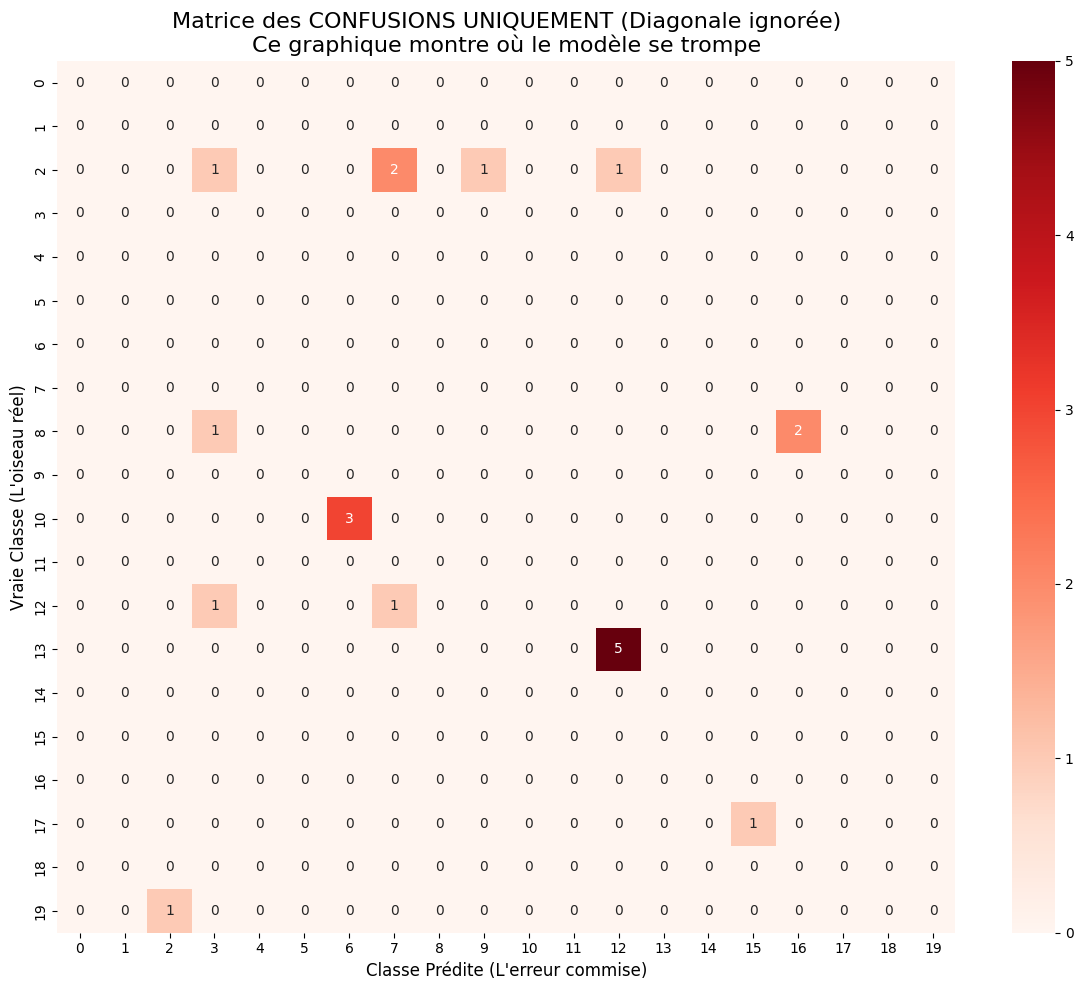


LES OISEAUX QUE LE MODÈLE N'ARRIVE PAS À PRÉDIRE (TOP 5 PIRES)
Classe 13 : Trouvé seulement 54.5% du temps.
   -> Souvent confondu avec la Classe 12 (5 erreurs)
------------------------------
Classe 02 : Trouvé seulement 58.3% du temps.
   -> Souvent confondu avec la Classe 7 (2 erreurs)
------------------------------
Classe 08 : Trouvé seulement 70.0% du temps.
   -> Souvent confondu avec la Classe 16 (2 erreurs)
------------------------------
Classe 10 : Trouvé seulement 70.0% du temps.
   -> Souvent confondu avec la Classe 6 (3 erreurs)
------------------------------
Classe 12 : Trouvé seulement 80.0% du temps.
   -> Souvent confondu avec la Classe 3 (1 erreurs)
------------------------------

RAPPORT COMPLET
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        11
           1      1.000     1.000     1.000        11
           2      0.875     0.583     0.700        12
           3      0.786     1.000     0.880        11
      

In [18]:
# ... (Tout le code précédent reste identique jusqu'à la partie 4) ...

# --- 4. VISUALISATION CIBLÉE SUR LES ERREURS ---
print("Génération de l'analyse des erreurs...")

# Calcul de la matrice originale
cm = confusion_matrix(y_true, y_pred)

# --- A. Matrice des Erreurs (Diagonale à 0) ---
# On crée une copie pour ne pas fausser les calculs suivants
cm_errors = cm.copy()
# On met la diagonale à 0 : on efface les bonnes réponses pour ne voir que les fautes
np.fill_diagonal(cm_errors, 0)

plt.figure(figsize=(12, 10))
# On utilise une colormap rouge pour bien souligner les erreurs
sns.heatmap(cm_errors, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title('Matrice des CONFUSIONS UNIQUEMENT (Diagonale ignorée)\nCe graphique montre où le modèle se trompe', fontsize=16)
plt.xlabel('Classe Prédite (L\'erreur commise)', fontsize=12)
plt.ylabel('Vraie Classe (L\'oiseau réel)', fontsize=12)
plt.tight_layout()
plt.show()

# --- B. Analyse Textuelle des Pires Classes ---
# Calcul du "Rappel" (Recall) par classe : Combien de fois on a trouvé le bon oiseau sur le nombre total
# cm.diagonal() = bons résultats / cm.sum(axis=1) = total d'oiseaux de cette classe
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# On trie pour avoir les pires en premier
worst_indices = np.argsort(class_accuracy)

print("\n" + "="*60)
print("LES OISEAUX QUE LE MODÈLE N'ARRIVE PAS À PRÉDIRE (TOP 5 PIRES)")
print("="*60)

for i in range(5): # Affiche les 5 pires
    idx = worst_indices[i]
    acc = class_accuracy[idx]
    print(f"Classe {idx:02d} : Trouvé seulement {acc:.1%} du temps.")
    
    # On regarde avec qui il est le plus souvent confondu
    # On prend la ligne de la classe, on met sa propre case à -1 pour l'ignorer
    row = cm[idx].copy()
    row[idx] = -1 
    most_confused_with = row.argmax()
    count = row[most_confused_with]
    
    print(f"   -> Souvent confondu avec la Classe {most_confused_with} ({count} erreurs)")
    print("-" * 30)

# --- 5. RAPPORT CLASSIQUE (Pour le détail complet si besoin) ---
print("\n" + "="*60)
print("RAPPORT COMPLET")
print("="*60)
print(classification_report(y_true, y_pred, digits=3))

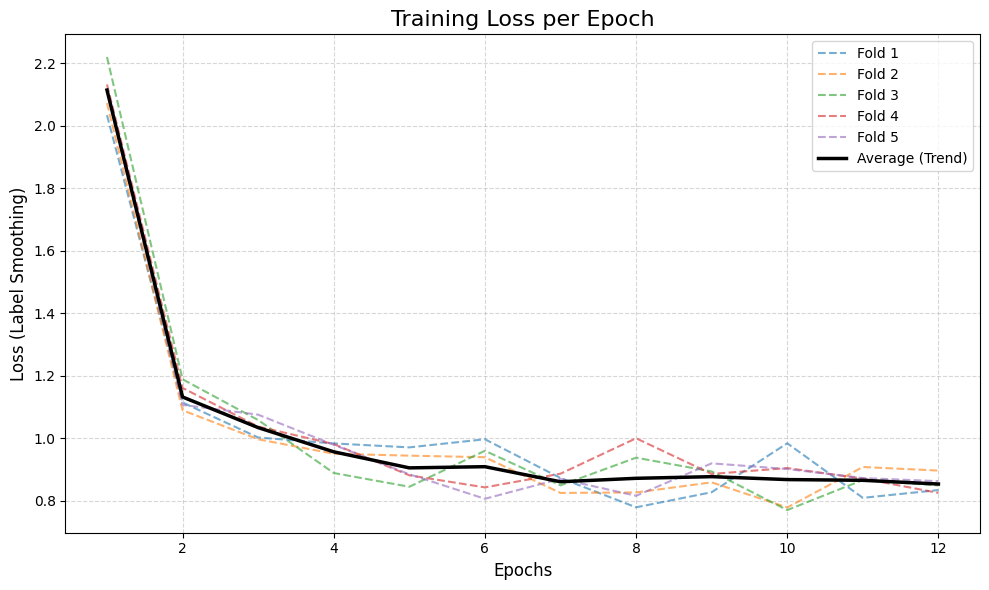

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATA FROM LOGS ---
history_data = {
    'Fold 1': {'loss': [2.0334, 1.1140, 1.0020, 0.9830, 0.9704, 0.9964, 0.8724, 0.7786, 0.8269, 0.9835, 0.8089, 0.8339]},
    'Fold 2': {'loss': [2.0721, 1.0891, 0.9963, 0.9500, 0.9439, 0.9389, 0.8246, 0.8262, 0.8585, 0.7781, 0.9076, 0.8962]},
    'Fold 3': {'loss': [2.2196, 1.1883, 1.0579, 0.8884, 0.8444, 0.9595, 0.8488, 0.9374, 0.8933, 0.7698, 0.8660, 0.8486]},
    'Fold 4': {'loss': [2.1317, 1.1606, 1.0370, 0.9809, 0.8810, 0.8424, 0.8862, 0.9995, 0.8854, 0.9042, 0.8706, 0.8247]},
    'Fold 5': {'loss': [2.1122, 1.1065, 1.0750, 0.9786, 0.8843, 0.8059, 0.8698, 0.8154, 0.9193, 0.9012, 0.8722, 0.8623]}
}

epochs = range(1, 13)
folds = list(history_data.keys())

# Calculate mean loss
all_losses = np.array([history_data[f]['loss'] for f in folds])
mean_loss = np.mean(all_losses, axis=0)

# --- PLOT LOSS ---
plt.figure(figsize=(10, 6))

# Plot each fold
for f in folds:
    plt.plot(epochs, history_data[f]['loss'], linestyle='--', alpha=0.6, label=f)

# Plot average trend
plt.plot(epochs, mean_loss, color='black', linewidth=2.5, label='Average (Trend)')

plt.title('Training Loss per Epoch', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (Label Smoothing)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and Show
plt.savefig('training_loss_english.png', dpi=300)
plt.show()

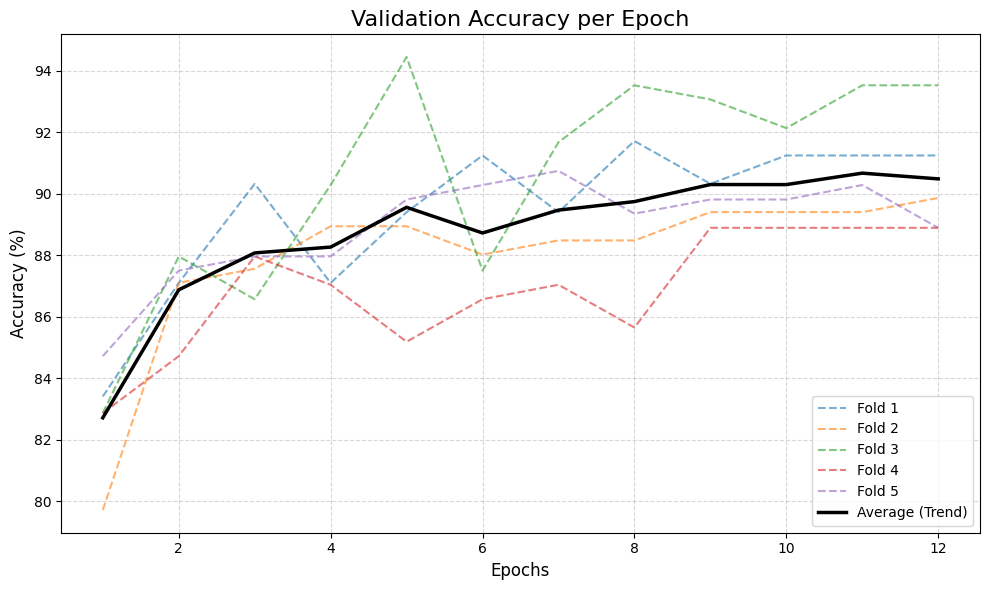

In [15]:
# --- 1. DATA FOR ACCURACY ---
# (Using same dictionary structure as above but for accuracy)
acc_data = {
    'Fold 1': [83.41, 87.10, 90.32, 87.10, 89.40, 91.24, 89.40, 91.71, 90.32, 91.24, 91.24, 91.24],
    'Fold 2': [79.72, 87.10, 87.56, 88.94, 88.94, 88.02, 88.48, 88.48, 89.40, 89.40, 89.40, 89.86],
    'Fold 3': [82.87, 87.96, 86.57, 90.28, 94.44, 87.50, 91.67, 93.52, 93.06, 92.13, 93.52, 93.52],
    'Fold 4': [82.87, 84.72, 87.96, 87.04, 85.19, 86.57, 87.04, 85.65, 88.89, 88.89, 88.89, 88.89],
    'Fold 5': [84.72, 87.50, 87.96, 87.96, 89.81, 90.28, 90.74, 89.35, 89.81, 89.81, 90.28, 88.89]
}

# Calculate mean accuracy
all_accs = np.array([acc_data[f] for f in folds])
mean_acc = np.mean(all_accs, axis=0)

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 6))

# Plot each fold
for f in folds:
    plt.plot(epochs, acc_data[f], linestyle='--', alpha=0.6, label=f)

# Plot average trend
plt.plot(epochs, mean_acc, color='black', linewidth=2.5, label='Average (Trend)')

plt.title('Validation Accuracy per Epoch', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and Show
plt.savefig('validation_accuracy_english.png', dpi=300)
plt.show()

In [20]:
# ================================================================
# FINE-TUNING CIBLÉ (BEST) — ajoute uniquement cette cellule
# Objectif: corriger les classes où le modèle se trompe le plus,
# sans refaire tout l'entraînement et en gardant EXACTEMENT la même
# normalisation que le training (custom_mean/custom_std).
# ================================================================

import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as TF
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from PIL import Image, ImageFile
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

# ------------------------
# 0) Helpers
# ------------------------
def _seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def _get_existing_var(name, default=None):
    return globals().get(name, default)

def _pick_best_fold_model_path(n_folds=5, prefer_fold_idx=2):
    # Priorité: fold préféré (par défaut fold 3 => index 2), sinon le premier qui existe.
    prefer = f"model_fold_{prefer_fold_idx}.pth"
    if os.path.exists(prefer):
        return prefer, prefer_fold_idx
    for i in range(n_folds):
        p = f"model_fold_{i}.pth"
        if os.path.exists(p):
            return p, i
    raise FileNotFoundError("Aucun fichier model_fold_*.pth trouvé dans le dossier courant.")

def _get_model(num_classes):
    m = models.convnext_tiny(weights=None)
    in_features = m.classifier[2].in_features
    m.classifier[2] = nn.Linear(in_features, num_classes)
    return m

class _BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row['path'])).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, int(row['class_idx'])

@torch.no_grad()
def _eval_on_fold0(model, df, img_dir, img_size, mean, std, batch_size=32, device='cpu'):
    # Reconstitue fold0 exactement comme dans tes cellules d'analyse
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf.split(df, df['class_idx']))
    val_df = df.iloc[val_idx].copy()
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    loader = DataLoader(_BirdDataset(val_df, img_dir, transform=tfm), batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval().to(device)
    y_true, y_pred = [], []
    for x, y in tqdm(loader, desc='Eval Fold0', leave=False):
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(y.numpy().tolist())
    cm = confusion_matrix(y_true, y_pred, labels=list(range(int(df['class_idx'].nunique()))))
    recall = np.divide(np.diag(cm), cm.sum(axis=1), out=np.zeros(cm.shape[0]), where=cm.sum(axis=1)!=0)
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return acc, recall, cm

def _top_hard_classes_from_cm(cm, topk=5):
    cm = np.asarray(cm)
    recall = np.divide(np.diag(cm), cm.sum(axis=1), out=np.zeros(cm.shape[0]), where=cm.sum(axis=1)!=0)
    worst = np.argsort(recall)[:topk].tolist()
    conf_map = {}
    for cls in worst:
        row = cm[cls].copy()
        row[cls] = -1
        conf = int(row.argmax())
        conf_map[int(cls)] = conf
    return worst, conf_map, recall

def _build_ft_dataframe(df, hard_classes, confused_classes, hard_multiplier=4, confused_multiplier=2, bg_fraction=0.35, seed=42, max_rows=2600):
    rng = np.random.RandomState(seed)
    df_hard = df[df['class_idx'].isin(hard_classes)]
    df_conf = df[df['class_idx'].isin(confused_classes)]
    df_bg = df[~df['class_idx'].isin(list(set(hard_classes) | set(confused_classes)))]
    parts = [df]  # garde un peu de global pour éviter l'oubli
    if len(df_hard) > 0:
        parts.append(pd.concat([df_hard] * max(1, int(hard_multiplier)), ignore_index=True))
    if len(df_conf) > 0:
        parts.append(pd.concat([df_conf] * max(1, int(confused_multiplier)), ignore_index=True))
    if len(df_bg) > 0 and bg_fraction > 0:
        bg_n = int(len(df) * bg_fraction)
        parts.append(df_bg.sample(n=min(bg_n, len(df_bg)), random_state=seed))
    df_ft = pd.concat(parts, ignore_index=True)
    df_ft = df_ft.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    if max_rows is not None and len(df_ft) > max_rows:
        df_ft = df_ft.sample(n=max_rows, random_state=seed).reset_index(drop=True)
    return df_ft

def _freeze_all(m):
    for p in m.parameters():
        p.requires_grad = False

def _unfreeze_classifier_and_last_stage(m):
    # Toujours classifier
    for p in m.classifier.parameters():
        p.requires_grad = True
    # Débloque le dernier stage de features (ConvNeXt: features est un Sequential)
    if hasattr(m, 'features') and len(m.features) > 0:
        for p in m.features[-1].parameters():
            p.requires_grad = True

def _train_one_epoch(model, loader, optimizer, criterion, device='cpu', desc='train'):
    model.train()
    total_loss = 0.0
    for x, y in tqdm(loader, desc=desc, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())
    return total_loss / max(1, len(loader))

@torch.no_grad()
def _tta10_predict_single(image_pil, model, img_size, mean, std, device='cpu'):
    # 10 vues: five_crop + hflip (comme ton code)
    image = image_pil.resize((280, 280))
    crops = list(TF.five_crop(image, img_size))
    flips = [TF.hflip(c) for c in crops]
    views = crops + flips
    tensors = [TF.normalize(TF.to_tensor(v), mean, std) for v in views]
    batch = torch.stack(tensors).to(device)
    logits = model(batch).mean(0)
    return int(logits.argmax().item())

# ------------------------
# 1) Config locale (CPU)
# ------------------------
class FTConfig:
    TRAIN_CSV = "train_metadata.csv"
    SUB_CSV = "sample_submission.csv"
    TRAIN_DIR = "train_images"
    TEST_DIR = os.path.join("test_images", "mistery_cat")
    NUM_CLASSES = 20
    IMG_SIZE = 256
    DEVICE = "cpu"
    SEED = 42
    # Fine-tuning params (court mais efficace)
    HEAD_EPOCHS = 1
    UNFREEZE_EPOCHS = 2
    LR_HEAD = 3e-4
    LR_UNFREEZE = 3e-5
    WEIGHT_DECAY = 1e-2
    BATCH_SIZE = 16
    # Poids sur les classes dures
    HARD_WEIGHT = 2.5
    # Sorties
    OUT_MODEL = "model_finetuned_best.pth"
    OUT_SUB = "submission_finetuned_best.csv"
    # Si tu as déjà chargé tes 5 modèles plus haut, on les utilise (meilleur score)
    USE_ENSEMBLE_IF_AVAILABLE = True

_seed_everything(FTConfig.SEED)

# ------------------------
# 2) Déterminer les classes "dures" (depuis y_true/y_pred si dispo, sinon depuis fold0 eval)
# ------------------------
df_all = pd.read_csv(FTConfig.TRAIN_CSV)

# Récupère tes stats custom si elles existent (c'est CRUCIAL)
custom_mean = _get_existing_var('custom_mean', None)
custom_std = _get_existing_var('custom_std', None)
if custom_mean is None or custom_std is None:
    print("[WARN] custom_mean/custom_std introuvables dans le kernel.")
    print("       Pour un fine-tuning optimal, exécute les cellules qui calculent custom_mean/custom_std, puis relance celle-ci.")
    print("       Fallback provisoire: stats ImageNet.")
    custom_mean = [0.485, 0.456, 0.406]
    custom_std = [0.229, 0.224, 0.225]

# Choix du meilleur modèle de départ (fold 3 index 2 par défaut)
base_path, base_fold_idx = _pick_best_fold_model_path(n_folds=5, prefer_fold_idx=2)
print(f"Base model: {base_path} (fold_idx={base_fold_idx})")

# Essaie d'utiliser y_true/y_pred déjà calculés (cellules confusion)
y_true = _get_existing_var('y_true', None)
y_pred = _get_existing_var('y_pred', None)
hard_classes = None
confused_map = {}
if isinstance(y_true, (list, tuple)) and isinstance(y_pred, (list, tuple)) and len(y_true) == len(y_pred) and len(y_true) > 0:
    cm0 = confusion_matrix(y_true, y_pred, labels=list(range(FTConfig.NUM_CLASSES)))
    hard_classes, confused_map, recall0 = _top_hard_classes_from_cm(cm0, topk=5)
    print("Hard classes détectées depuis y_true/y_pred:", hard_classes)
else:
    # Re-évalue fold0 avec la normalisation custom pour décider proprement
    tmp = _get_model(FTConfig.NUM_CLASSES)
    tmp.load_state_dict(torch.load(base_path, map_location=FTConfig.DEVICE))
    acc_before, recall_before, cm_before = _eval_on_fold0(tmp, df_all, FTConfig.TRAIN_DIR, FTConfig.IMG_SIZE, custom_mean, custom_std, batch_size=32, device=FTConfig.DEVICE)
    hard_classes, confused_map, _ = _top_hard_classes_from_cm(cm_before, topk=5)
    print(f"Fold0 acc (before): {acc_before:.4f}")
    print("Hard classes (fold0, custom stats):", hard_classes)
    del tmp

confused_classes = sorted(list(set(confused_map.values())))
print("Confusions principales (classe -> confondue avec):", confused_map)
print("Classes 'confused' ajoutées au fine-tuning:", confused_classes)

# ------------------------
# 3) Construire dataset de fine-tuning (boost hard + confusions + un peu de global)
# ------------------------
df_ft = _build_ft_dataframe(
    df_all,
    hard_classes=hard_classes,
    confused_classes=confused_classes,
    hard_multiplier=4,
    confused_multiplier=2,
    bg_fraction=0.25,
    seed=FTConfig.SEED,
    max_rows=2600,
)
print(f"Dataset FT: {len(df_ft)} images (hard={hard_classes}, confused={confused_classes})")

# Transforms: légères + même normalisation
train_tf = transforms.Compose([
    transforms.Resize((FTConfig.IMG_SIZE, FTConfig.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(7),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.10, hue=0.0),
    transforms.ToTensor(),
    transforms.Normalize(custom_mean, custom_std),
])

train_loader = DataLoader(
    _BirdDataset(df_ft, FTConfig.TRAIN_DIR, transform=train_tf),
    batch_size=FTConfig.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

# ------------------------
# 4) Charger modèle + fine-tune en 2 étapes (head puis last stage)
# ------------------------
model = _get_model(FTConfig.NUM_CLASSES).to(FTConfig.DEVICE)
model.load_state_dict(torch.load(base_path, map_location=FTConfig.DEVICE))

# Loss pondérée: focus sur classes dures
weights = torch.ones(FTConfig.NUM_CLASSES, dtype=torch.float32)
for c in hard_classes:
    weights[int(c)] = FTConfig.HARD_WEIGHT
criterion = nn.CrossEntropyLoss(weight=weights.to(FTConfig.DEVICE))

# (A) Head only
_freeze_all(model)
for p in model.classifier.parameters():
    p.requires_grad = True
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=FTConfig.LR_HEAD, weight_decay=FTConfig.WEIGHT_DECAY)

print("\n[FT] Stage A — head only")
for epoch in range(FTConfig.HEAD_EPOCHS):
    loss = _train_one_epoch(model, train_loader, opt, criterion, device=FTConfig.DEVICE, desc=f"FT-A {epoch+1}/{FTConfig.HEAD_EPOCHS}")
    print(f"  loss: {loss:.4f}")

# (B) Unfreeze last stage + classifier
_freeze_all(model)
_unfreeze_classifier_and_last_stage(model)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=FTConfig.LR_UNFREEZE, weight_decay=FTConfig.WEIGHT_DECAY)

print("\n[FT] Stage B — unfreeze last stage")
for epoch in range(FTConfig.UNFREEZE_EPOCHS):
    loss = _train_one_epoch(model, train_loader, opt, criterion, device=FTConfig.DEVICE, desc=f"FT-B {epoch+1}/{FTConfig.UNFREEZE_EPOCHS}")
    print(f"  loss: {loss:.4f}")

# Sauvegarde
torch.save(model.state_dict(), FTConfig.OUT_MODEL)
print(f"\nOK: modèle finetuné sauvegardé -> {FTConfig.OUT_MODEL}")

# ------------------------
# 5) Eval avant/après sur fold0 (avec stats custom) + focus hard classes
# ------------------------
base_model = _get_model(FTConfig.NUM_CLASSES).to(FTConfig.DEVICE)
base_model.load_state_dict(torch.load(base_path, map_location=FTConfig.DEVICE))
acc_b, rec_b, _ = _eval_on_fold0(base_model, df_all, FTConfig.TRAIN_DIR, FTConfig.IMG_SIZE, custom_mean, custom_std, batch_size=32, device=FTConfig.DEVICE)
acc_a, rec_a, _ = _eval_on_fold0(model, df_all, FTConfig.TRAIN_DIR, FTConfig.IMG_SIZE, custom_mean, custom_std, batch_size=32, device=FTConfig.DEVICE)

print("\n=== Fold0 (custom stats) — Before vs After ===")
print(f"ACC: {acc_b:.4f} -> {acc_a:.4f}")
for c in hard_classes:
    c = int(c)
    print(f"Recall class {c:02d}: {rec_b[c]:.3f} -> {rec_a[c]:.3f}")

# ------------------------
# 6) Génération submission (meilleur effort):
#    - si ensemble déjà chargé (models_list) -> remplace le fold de base par le finetuné
#    - sinon -> single model + TTA10
# ------------------------
sub_df = pd.read_csv(FTConfig.SUB_CSV)
test_paths = sub_df['path'].tolist()
preds = []

use_ensemble = FTConfig.USE_ENSEMBLE_IF_AVAILABLE and isinstance(_get_existing_var('models_list', None), list) and len(_get_existing_var('models_list')) > 0
tta_inference_func = _get_existing_var('tta_inference', None)

start = time.time()
print(f"\nSubmission: {len(test_paths)} images | ensemble={use_ensemble}")

if use_ensemble and callable(tta_inference_func):
    # Remplace/ajoute le modèle du fold de base par le finetuné
    models_list = _get_existing_var('models_list')
    finetuned_for_ensemble = _get_model(FTConfig.NUM_CLASSES).to(FTConfig.DEVICE)
    finetuned_for_ensemble.load_state_dict(torch.load(FTConfig.OUT_MODEL, map_location=FTConfig.DEVICE))
    finetuned_for_ensemble.eval()
    if base_fold_idx < len(models_list):
        models_list[base_fold_idx] = finetuned_for_ensemble
    else:
        models_list.append(finetuned_for_ensemble)
    # Utilise ta TTA + ensemble déjà définie plus haut
    for img_name in tqdm(test_paths, desc='Infer ensemble+TTA', leave=False):
        img = Image.open(os.path.join(FTConfig.TEST_DIR, img_name)).convert('RGB')
        preds.append(int(tta_inference_func(img, models_list)))
else:
    # Single model + TTA10 (rapide)
    model.eval()
    for img_name in tqdm(test_paths, desc='Infer single TTA10', leave=False):
        img = Image.open(os.path.join(FTConfig.TEST_DIR, img_name)).convert('RGB')
        preds.append(_tta10_predict_single(img, model, FTConfig.IMG_SIZE, custom_mean, custom_std, device=FTConfig.DEVICE))

sub_df['class_idx'] = preds
sub_df.to_csv(FTConfig.OUT_SUB, index=False)
print(f"OK: {FTConfig.OUT_SUB} | temps {(time.time()-start)/60:.1f} min")

Base model: model_fold_2.pth (fold_idx=2)
Hard classes détectées depuis y_true/y_pred: [13, 2, 8, 10, 12]
Confusions principales (classe -> confondue avec): {13: 12, 2: 7, 8: 16, 10: 6, 12: 3}
Classes 'confused' ajoutées au fine-tuning: [3, 6, 7, 12, 16]
Dataset FT: 2600 images (hard=[13, 2, 8, 10, 12], confused=[3, 6, 7, 12, 16])


C:\Users\Hp\AppData\Local\Temp\ipykernel_24348\1978264629.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(base_path, map_location=FTCo


[FT] Stage A — head only


  loss: 0.1323

[FT] Stage B — unfreeze last stage


  loss: 0.0665


  loss: 0.0339

OK: modèle finetuné sauvegardé -> model_finetuned_best.pth


C:\Users\Hp\AppData\Local\Temp\ipykernel_24348\1978264629.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(base_path, map_location


=== Fold0 (custom stats) — Before vs After ===
ACC: 0.9954 -> 1.0000
Recall class 13: 0.909 -> 1.000
Recall class 02: 1.000 -> 1.000
Recall class 08: 1.000 -> 1.000
Recall class 10: 1.000 -> 1.000
Recall class 12: 1.000 -> 1.000

Submission: 400 images | ensemble=True


C:\Users\Hp\AppData\Local\Temp\ipykernel_24348\1978264629.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetuned_for_ensemble.load_state_dict(torch.load(FTConfig.OU

OK: submission_finetuned_best.csv | temps 47.0 min
